### Notebook to Run Individual *in silico* JCVI-syn3A Simulations Serially (with example analysis)

In [1]:
# Import Lattice Microbes Software Suite (https://github.com/zanert2/Lattice_Microbes) modules
import lm

In [2]:
### Set possible runtime and analysis arguments
time = 2 # minutes
restartTime = 1 # minutes

## Use a bash shell magic to run a single simulation

In [3]:
%%bash

### Simulation Arguments
### -procid, the processID (i.e. 1,2,3 ...)
### -t, the total simulation time (in minutes, cell cycle = 120 minutes to ensure simulation of full cell cycles)
### -rs, the restart time (in minutes, default = 1)

python3 MinCell_CMEODE.py -procid 1 -t 1  ### args (time should be 1 minute here, to set initial conditions)
python3 MinCell_restart.py -procid 1 -t 2 -rs 1 ### args (the time here should be the desired simulation time)

Locus  JCVSYN2_00155  has no AOE id!
Locus  JCVSYN2_01555  has no AOE id!
Locus  JCVSYN2_01600  has no AOE id!
Locus  JCVSYN2_02325  has no AOE id!
Locus  JCVISYN3A_0051  is pseudo.
Locus  JCVISYN3A_0546  is pseudo.
Locus  JCVISYN3A_0602  is pseudo.
Please use only supported column types!
Please use only supported column types!
Please use only supported column types!
Please use only supported column types!
Please use only supported column types!
Please use only supported column types!
Please use only supported column types!
Please use only supported column types!
Please use only supported column types!
Please use only supported column types!
Please use only supported column types!
Please use only supported column types!
Please use only supported column types!
Please use only supported column types!
Please use only supported column types!
M_g6p_c
M_g6p_c 74819
M_g1p_c
M_g1p_c 2018
M_f6p_c
M_f6p_c 17230
M_man6p_c
M_man6p_c 2018
M_gam6p_c
M_gam6p_c 14231
M_acgam6p_c
M_acgam6p_c 2018
M_acm

100%|##########| 1/1 [01:21<00:00, 81.08s/it]


### Some simple Analysis to plot out individual species

Documentation for analysis unctionality can be accessed via **'?myMethod'**

*e.g* ?pp.openLMFile 

to return a docstring

In [4]:
# Import needed modules
import numpy as np
import sys
import os
import glob
import lm as lm
from pyLM import *

from pySTDLM import PostProcessing as pp

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
pp.openLMFile?

Signature: pp.openLMFile(filename)
Docstring:
Open a Lattice Microbes File for reading

Args:
    filename:
        Name of the file
Returns:
    a handle to the file
File:      ~/.pyenv/versions/miniconda3-4.7.12/envs/minimal-cell/lib/python3.7/site-packages/pyLM-2.4.0-py3.7.egg/pySTDLM/PostProcessing.py
Type:      function


In [6]:
times=np.arange(0,time+1,1)
numSims=1

In [7]:
# Sets sims folder to your current working directory ... you can modify this if needed
simsFolder = '../simulations/'
fn='out-1.lm'# siingle simulation file

In [8]:
# Get a list of all chemical species (genes, RNA, proteins etc.) tracked in the simulation
fh = pp.openLMFile(simsFolder+fn)
spec_list=pp.getSpecies(fh)

In [9]:
%%bash
# Check that we are in the correct directory
pwd

/mnt2/home/hishida/projects/mincell/Minimal_Cell_his/CME_ODE/program


In [10]:
glob.glob(simsFolder+'*.csv')

['../simulations/rep-1.csv']

In [11]:
# Get traces of all cells
def getTraces(sL,numSims,times):
    fileList=[]
    traceArr = np.zeros((numSims,len(sL),len(times)))
    # os.chdir(simsFolder)
    for i, my_file in enumerate(glob.glob(simsFolder+"*.csv")):
        print(my_file)
        fileList.append(my_file)
        df = pd.read_csv(str(my_file),header=0)
        for j,time in enumerate(times):
            if (j == 0):
                startVal = 0
                endVal=len(sL)
            else:
                startVal=((len(sL)+1)*j)
                endVal=(len(sL)+1)*(j+1)-1
            traceArr[i,:,j] = df[startVal:endVal]['0.0'][:]
    return traceArr,fileList

In [12]:
ta,fL = getTraces(spec_list,numSims,times)

../simulations/rep-1.csv


In [13]:
# Set beginning and ending times for plottting
startTime=0
endTime=times[-1]

In [14]:
zeros = np.zeros((numSims,len(spec_list),len(times)))

75


Text(0.5, 1.0, "['M_atp_c']")

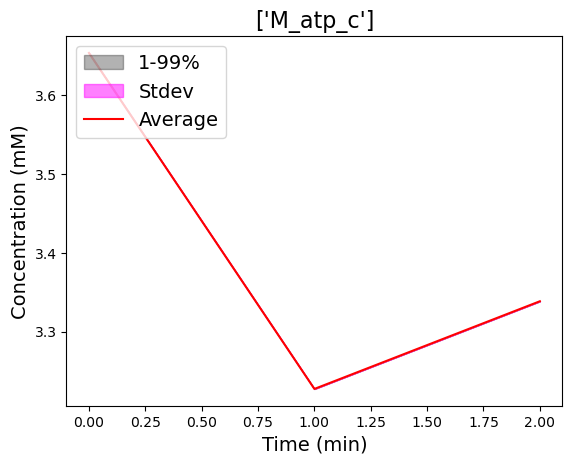

In [15]:
# Plot a chemical species concentration
species_list = ['M_atp_c']
times = np.arange(startTime,endTime+1,1)

specInd = spec_list.index(species_list[0])
vInd=spec_list.index('CellV')
print(specInd)
# 1e-19 conversion factor since 'Volume' is stored as in 10^-19 L to give values of 335 for IC etc.
conc = ta[:,specInd,startTime:endTime+1]*1000.0/(ta[:,vInd,startTime:endTime+1]*1e-19*6.022e23)

plt.fill_between(times[:],np.percentile(conc,1,axis=0),np.percentile(conc,99,axis=0),alpha=0.3,label='1-99%',color='black')
plt.fill_between(times[:],np.average(conc,axis=0)+np.std(conc,axis=0),np.maximum(np.average(conc,axis=0)-np.std(conc,axis=0),zeros[0,0,:]),alpha=0.5,label='Stdev',color='magenta')
plt.plot(times[:],np.median(conc,axis=0),label='Average',color='red')

plt.ylabel('Concentration (mM)',fontsize=14)
plt.xlabel('Time (min)',fontsize=14)
#plt.ylim(0,5)
plt.legend(fontsize=14,loc='upper left')
plt.title(species_list,fontsize=16)

### Plot out Particle Number instead of concentration

For example, let's look at the enzyme Fructose Bisphosphate Aldolase (*fba*, /JCVISYN3A_0131).

As we can see, even after a few minutes several copies of this main glycolysis pathway enzyme are translated.

In [19]:
# Get particle counts
def getParts(ta,specInd,startTime,endTime):
    parts=ta[:,specInd,startTime:endTime+1]
    return parts

In [20]:
# Get average minus standard deviation
def sdMinus(conc):
    arr=np.maximum(np.average(conc,axis=0)-np.std(conc,axis=0),zeros[0,0,:])
    return arr

Text(0.5, 1.0, "['M_DnaA_c']")

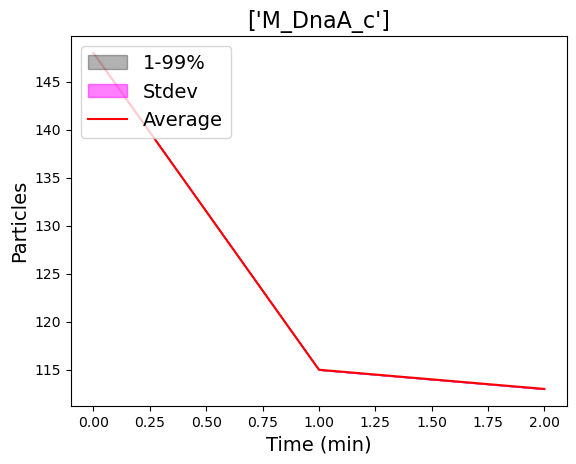

In [21]:
# Plot a chemical species in number of particles
species_list = ['M_DnaA_c']
times = np.arange(startTime,endTime+1,1)

specInd = spec_list.index(species_list[0])
conc = getParts(ta,specInd,startTime,endTime)

plt.fill_between(times[:],np.percentile(conc,1,axis=0),np.percentile(conc,99,axis=0),alpha=0.3,label='1-99%',color='black')
plt.fill_between(times[:],np.average(conc,axis=0)+np.std(conc,axis=0),sdMinus(conc),alpha=0.5,label='Stdev',color='magenta')
plt.plot(times[:],np.average(conc,axis=0),label='Average',color='red')

plt.ylabel('Particles',fontsize=14)
plt.xlabel('Time (min)',fontsize=14)
plt.legend(fontsize=14,loc='upper left')
plt.title(species_list,fontsize=16)

## Now let's look at the reaction fluxes for a few reactions

In [22]:
# Sets the fluxes folder to simulations directory (cwd) + the fluxes directory
fluxesFolder = simsFolder+'/fluxes/'

#simTime = 121 # min
#times=np.arange(0,simTime,1)

In [23]:
# Quick check of flux file contents (.csv with: rxnID, flux (mM/s))
myfile='rep-1-fluxDF_final.csv'
df=pd.read_csv(fluxesFolder+str(myfile),header=None)
df.head()

,0,1,2
0,0,PGI,0.855742
1,1,PFK,0.882824
2,2,FBA,0.752053
3,3,TPI,0.748258
4,4,GAPD,1.465645


In [24]:
# Get the reaction IDs from the flux file ... 175 non-redundant metabolic reactions
def getRxnList(path):
    fn = path+'rep-1-fluxDF_final.csv'
    df=pd.read_csv(fn,header=None)
    rxn_list = df[0:175][1][:].tolist()
    return rxn_list

In [25]:
# List of reaction IDs
rL = getRxnList(fluxesFolder)

In [26]:
# Get particle counts, here we will use this to get an array of fluxes (imagining them as particle count values)
def getParts(ta,specInd,startTime,endTime):
    parts=ta[:,specInd,startTime:endTime+1]
    return parts

In [29]:
%%bash 
pwd

/root/project/Minimal_Cell_his/CME_ODE/program


In [30]:
# Get reaction flux traces for all simulated cells
def getTraces():
    traceArr = np.zeros((numSims,len(rL),len(times)))
    for i, my_file in enumerate(glob.glob(fluxesFolder+"*.csv")):
        print(my_file)
        df = pd.read_csv(str(my_file),header=None)
        for j,time in enumerate(times):
            if (j == 0):
                #print(j)
                startVal = 0
                endVal=len(rL)
                traceArr[i,:,j] = df[startVal:endVal][2][:].values
            else:
                print(j)
                startVal=(len(rL)*j)
                endVal=len(rL)*(j+1)
            #print('start:',startVal,'end:',endVal)
                traceArr[i,:,j] = df[startVal:endVal][1][:].values.astype(float)
    return traceArr

In [31]:
fluxArr = getTraces()

../simulations//fluxes/rep-1-fluxDF_final.csv
1
2


### Let's look at the fructose bisphosphate aldolase (FBA) reaction from before

Using this functionality we can observe how the reaction flux (*i.e.* concentration of substrate converted to product produced per unit time - mM/s) might change due to variables like:

- available enzyme catalyzing the reaction (M_PTN_JCVISYN3A_0131_c)

- available substrates for the reaction (M_fdp_c - fructose diphosphate, M_atp_c -ATP)

- flux through upstream reactions (PFK - phosphofructokinase converase of F6P to FDP)

Text(0.5, 1.0, "['FBA']")

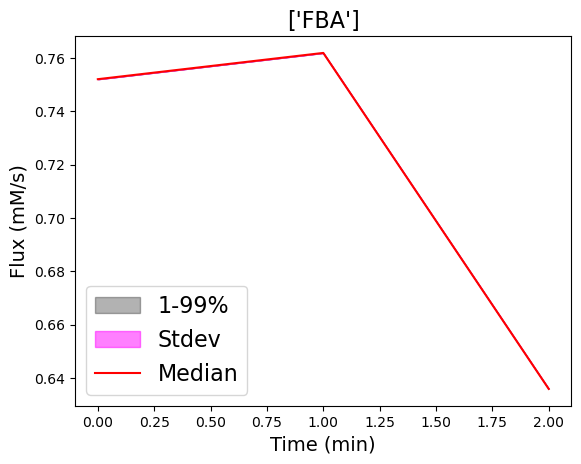

In [32]:
rxn_list = ['FBA']
times = np.arange(startTime,endTime+1,1)

rxnInd = rL.index(rxn_list[0])
flux = getParts(fluxArr,rxnInd,startTime,endTime)

plt.fill_between(times[:],np.percentile(flux,1,axis=0),np.percentile(flux,99,axis=0),alpha=0.3,label='1-99%',color='black')
plt.fill_between(times[:],np.average(flux,axis=0)+np.std(flux,axis=0),np.average(flux,axis=0)-np.std(flux,axis=0),alpha=0.5,label='Stdev',color='magenta')
plt.plot(times[:],np.median(flux,axis=0),label='Median',color='red')

plt.ylabel('Flux (mM/s)',fontsize=14)
plt.xlabel('Time (min)',fontsize=14)
plt.legend(fontsize=16,loc='lower left')
plt.title(rxn_list,fontsize=16)